# CNN untuk Klasifikasi Sampah Otomatis

**Tugas:** Membangun model CNN dari awal untuk klasifikasi 5 jenis sampah (foodwaste, glass, metal, paper, plastic) untuk sistem pemisah sampah otomatis.

**Konfigurasi:** Menggunakan setting ringan untuk laptop dengan spesifikasi rendah.

In [11]:
# Import libraries yang diperlukan untuk CNN, image processing, dan evaluasi model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import cv2
import pickle
from pathlib import Path
import pandas as pd

# Setup path untuk dataset, model, dan report
BASE_DIR = Path('.')
DATASET_DIR = BASE_DIR / 'datasets'
MODEL_DIR = BASE_DIR / 'models'
REPORT_DIR = BASE_DIR / 'report'

# Pastikan folder model dan report ada
MODEL_DIR.mkdir(exist_ok=True)
REPORT_DIR.mkdir(exist_ok=True)

# Konfigurasi untuk laptop dengan spec rendah
IMG_SIZE = 64  
BATCH_SIZE = 16  
EPOCHS = 100  # Increased untuk model lebih dalam
VALIDATION_SPLIT = 0.2

# Class names untuk klasifikasi sampah
CLASS_NAMES = ['foodwaste', 'glass', 'metal', 'paper', 'plastic']
NUM_CLASSES = len(CLASS_NAMES)

print(f"TensorFlow version: {tf.__version__}")
print(f"Dataset directory: {DATASET_DIR}")
print(f"Class names: {CLASS_NAMES}")
print(f"Configuration - Image size: {IMG_SIZE}x{IMG_SIZE}, Batch size: {BATCH_SIZE}, Epochs: {EPOCHS}")


TensorFlow version: 2.20.0
Dataset directory: datasets
Class names: ['foodwaste', 'glass', 'metal', 'paper', 'plastic']
Configuration - Image size: 64x64, Batch size: 16, Epochs: 100


Loading SEMUA data dari folder train...
  Found 970 images for class: foodwaste
    Loading 500/970 images...
    Loading 500/970 images...
  ✓ Loaded 970 images for foodwaste
  Found 954 images for class: glass
  ✓ Loaded 970 images for foodwaste
  Found 954 images for class: glass
    Loading 500/954 images...
    Loading 500/954 images...
  ✓ Loaded 954 images for glass
  Found 1713 images for class: metal
  ✓ Loaded 954 images for glass
  Found 1713 images for class: metal
    Loading 500/1713 images...
    Loading 500/1713 images...
    Loading 1000/1713 images...
    Loading 1000/1713 images...
    Loading 1500/1713 images...
    Loading 1500/1713 images...
  ✓ Loaded 1713 images for metal
  Found 2267 images for class: paper
  ✓ Loaded 1713 images for metal
  Found 2267 images for class: paper
    Loading 500/2267 images...
    Loading 500/2267 images...
    Loading 1000/2267 images...
    Loading 1000/2267 images...
    Loading 1500/2267 images...
    Loading 1500/2267 images..

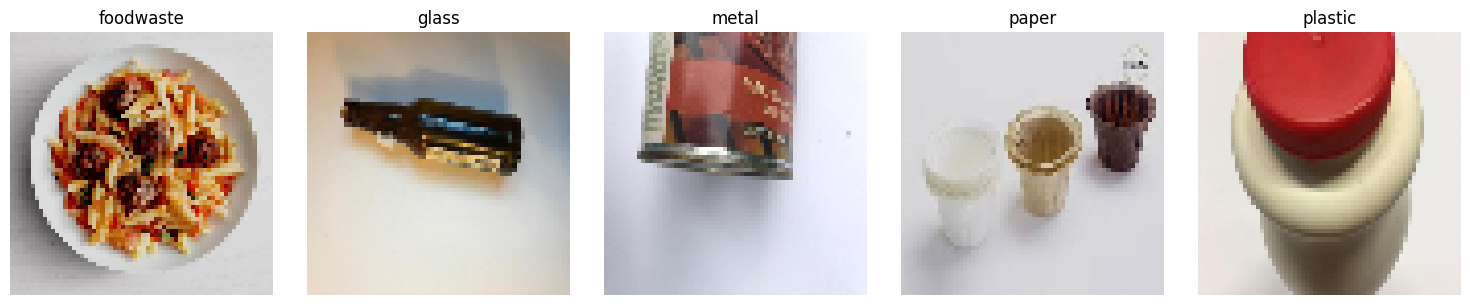


✓ Data loading completed! (All images from train folder)


In [12]:
# Load semua gambar dari folder train tanpa batasan
# Kemudian split menjadi train, validation, dan test

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import cv2

# Setup ImageDataGenerator dengan data augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Setup ImageDataGenerator tanpa augmentation untuk validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Load SEMUA gambar dari folder train TANPA BATASAN
print("Loading SEMUA data dari folder train...")
train_dir = DATASET_DIR / 'train'
all_images = []
all_labels = []

# Load semua gambar dari setiap class tanpa batasan
for class_idx, class_name in enumerate(CLASS_NAMES):
    class_path = train_dir / class_name
    if class_path.exists():
        image_files = list(class_path.glob('*.jpg'))
        total_images = len(image_files)
        print(f"  Found {total_images} images for class: {class_name}")
        
        # LOAD SEMUA TANPA BATASAN
        for img_idx, img_file in enumerate(image_files):
            if (img_idx + 1) % 500 == 0:
                print(f"    Loading {img_idx + 1}/{total_images} images...")
            
            try:
                img = cv2.imread(str(img_file))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = img.astype(np.float32) / 255.0
                all_images.append(img)
                all_labels.append(class_idx)
            except Exception as e:
                print(f"  Error loading {img_file}: {e}")
        
        print(f"  ✓ Loaded {len([l for l in all_labels if l == class_idx])} images for {class_name}")

# Convert ke numpy array
X_all = np.array(all_images)
y_all = np.array(all_labels)

print(f"\n" + "="*80)
print("TOTAL DATA LOADED")
print("="*80)
print(f"Total samples: {len(X_all)}")
print(f"Image shape: {X_all[0].shape}")
print(f"Data shape: {X_all.shape}")

# Split data menjadi train (70%) dan validation (30%)
X_train_data, X_val_data, y_train_data, y_val_data = train_test_split(
    X_all, y_all, test_size=0.3, random_state=42, stratify=y_all
)

print(f"\nAfter first split:")
print(f"  Training set: {X_train_data.shape[0]} samples")
print(f"  Validation set: {X_val_data.shape[0]} samples")

# Split training data menjadi train (70% dari 70%) dan test (30% dari 70%)
X_train_final, X_test_data, y_train_final, y_test_data = train_test_split(
    X_train_data, y_train_data, test_size=0.3, random_state=42, stratify=y_train_data
)

print(f"\nAfter second split (from training set):")
print(f"  Final Train: {X_train_final.shape[0]} samples (~49% dari total)")
print(f"  Final Test: {X_test_data.shape[0]} samples (~21% dari total)")

# Update X_train_data untuk menggunakan final training data
X_train_data = X_train_final
y_train_data = y_train_final

# Print informasi dataset lengkap
print(f"\n" + "="*80)
print("FINAL DATASET INFORMATION")
print("="*80)
print(f"Training samples:   {X_train_data.shape[0]}")
print(f"Validation samples: {X_val_data.shape[0]}")
print(f"Test samples:       {X_test_data.shape[0]}")
print(f"Total:              {X_train_data.shape[0] + X_val_data.shape[0] + X_test_data.shape[0]}")
print(f"\nImage size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {CLASS_NAMES}")

# Print class distribution
print(f"\n" + "-"*80)
print("CLASS DISTRIBUTION")
print("-"*80)
print("\nTraining set:")
for i, class_name in enumerate(CLASS_NAMES):
    count = np.sum(y_train_data == i)
    percentage = (count / len(y_train_data)) * 100
    print(f"  - {class_name:15s}: {count:4d} samples ({percentage:5.1f}%)")

print("\nValidation set:")
for i, class_name in enumerate(CLASS_NAMES):
    count = np.sum(y_val_data == i)
    percentage = (count / len(y_val_data)) * 100
    print(f"  - {class_name:15s}: {count:4d} samples ({percentage:5.1f}%)")

print("\nTest set:")
for i, class_name in enumerate(CLASS_NAMES):
    count = np.sum(y_test_data == i)
    percentage = (count / len(y_test_data)) * 100
    print(f"  - {class_name:15s}: {count:4d} samples ({percentage:5.1f}%)")

# Visualisasi sample gambar dari setiap kelas
print("\n" + "-"*80)
print("VISUALIZING SAMPLE IMAGES")
print("-"*80)
plt.figure(figsize=(15, 3))
for i in range(NUM_CLASSES):
    # Cari sample pertama dari setiap class di training set
    class_indices = np.where(y_train_data == i)[0]
    if len(class_indices) > 0:
        sample_img = X_train_data[class_indices[0]]
        plt.subplot(1, NUM_CLASSES, i+1)
        plt.imshow(sample_img)
        plt.title(f"{CLASS_NAMES[i]}")
        plt.axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Data loading completed! (All images from train folder)")


In [13]:
# Desain arsitektur CNN yang SEDERHANA dan mudah train
# Model dioptimasi untuk convergence lebih cepat dengan limited data

def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    """Membuat model CNN yang lebih dalam untuk better convergence"""
    
    model = keras.Sequential([
        # Layer input
        keras.Input(shape=input_shape),
        
        # Convolutional Layer 1 - lebih banyak filter untuk feature extraction
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1'),
        layers.BatchNormalization(name='bn1'),
        layers.MaxPooling2D((2, 2), name='pool1'),
        layers.Dropout(0.1, name='dropout1'),
        
        # Convolutional Layer 2
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2'),
        layers.BatchNormalization(name='bn2'),
        layers.MaxPooling2D((2, 2), name='pool2'),
        layers.Dropout(0.1, name='dropout2'),
        
        # Convolutional Layer 3 - untuk lebih dalam
        layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3'),
        layers.BatchNormalization(name='bn3'),
        layers.MaxPooling2D((2, 2), name='pool3'),
        layers.Dropout(0.1, name='dropout3'),
        
        # Global Average Pooling untuk reduce parameters
        layers.GlobalAveragePooling2D(name='gap'),
        
        # Dense layers - lebih kecil untuk regularization
        layers.Dense(256, activation='relu', name='dense1'),
        layers.BatchNormalization(name='bn4'),
        layers.Dropout(0.15, name='dropout4'),
        
        layers.Dense(128, activation='relu', name='dense2'),
        layers.BatchNormalization(name='bn5'),
        layers.Dropout(0.15, name='dropout5'),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax', name='output')
    ], name='WasteClassificationCNN')
    
    return model

# Buat model CNN
model = create_cnn_model()

# Compile model dengan learning rate yang lebih rendah untuk stable convergence
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Turun dari 0.005 untuk stable
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan arsitektur model
print("=" * 80)
print("MODEL ARCHITECTURE - WASTE CLASSIFICATION CNN (IMPROVED)")
print("=" * 80)
model.summary()

# Print training configuration
print("\n" + "=" * 80)
print("MODEL CONFIGURATION")
print("=" * 80)
print(f"Total Parameters: {model.count_params():,}")
print(f"Input Shape: {model.input_shape}")
print(f"Output Shape: {model.output_shape}")
print(f"Number of Layers: {len(model.layers)}")
print(f"\nTraining Settings:")
print(f"  - Optimizer: Adam (initial lr=0.0005)")
print(f"  - Loss Function: Sparse Categorical Crossentropy")
print(f"  - Metrics: Accuracy")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  - EarlyStopping: patience=15")
print(f"  - ReduceLROnPlateau: patience=5, factor=0.5")
print(f"  - LearningRateScheduler: 0.0005 (0-9ep) → 0.0002 (10-29ep) → 0.0001 (30+ep)")
print("=" * 80 + "\n")


MODEL ARCHITECTURE - WASTE CLASSIFICATION CNN (IMPROVED)


Model: "WasteClassificationCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 16, 16, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout4 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout5 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 473,477 (1.81 MB)

 Trainable params: 471,813 (1.80 MB)

 Non-trainable params: 1,664 (6.50 KB)


MODEL CONFIGURATION
Total Parameters: 473,477
Input Shape: (None, 64, 64, 3)
Output Shape: (None, 5)
Number of Layers: 20

Training Settings:
  - Optimizer: Adam (initial lr=0.0005)
  - Loss Function: Sparse Categorical Crossentropy
  - Metrics: Accuracy
  - Epochs: 100
  - Batch Size: 16
  - Image Size: 64x64
  - EarlyStopping: patience=15
  - ReduceLROnPlateau: patience=5, factor=0.5
  - LearningRateScheduler: 0.0005 (0-9ep) → 0.0002 (10-29ep) → 0.0001 (30+ep)



STARTING MODEL TRAINING (IMPROVED ARCHITECTURE)
Configuration:
  - Model: 3 Conv layers (64, 128, 256 filters) + GlobalAveragePooling
  - Epochs: 100
  - Batch size: 16
  - Training samples: 4116
  - Validation samples: 2520
  - Steps per epoch: 257
  - Learning rate: 0.0005 (schedule: 0.0005 → 0.0002 → 0.0001)
  - Image size: 64x64
  - BatchNormalization: Yes (untuk stable training)
  - Dropout: 0.1-0.15 (reduced from 0.2-0.3)


Epoch 1: LearningRateScheduler setting learning rate to 0.0005.
Epoch 1/100
Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 48s 175ms/step - accuracy: 0.4509 - loss: 1.4609 - val_accuracy: 0.3702 - val_loss: 1.8666 - learning_rate: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005.
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 48s 175ms/step - accuracy: 0.4509 - loss: 1.4609 - val_accuracy: 0.3702 - val_loss: 1.8666 - learning_rate: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005.
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━

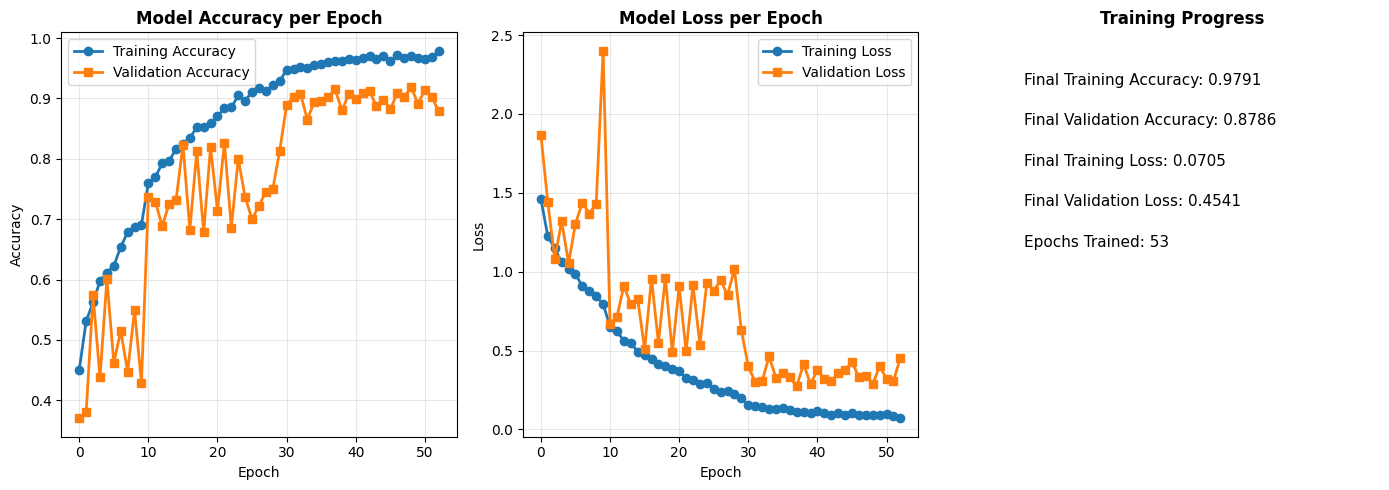


✓ Training curves saved to report/training_curves.png

TRAINING SUMMARY
Final training accuracy:   0.9791
Final validation accuracy: 0.8786
Final training loss:       0.0705
Final validation loss:     0.4541
Total epochs trained:      53


In [14]:
# Training model dengan numpy arrays dari train/val split
# Dengan adjustments untuk convergence yang lebih baik

# Setup callback dengan adjustment yang lebih agresif untuk better convergence
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,  # Lebih banyak kesempatan untuk converge
        restore_best_weights=True,
        verbose=1,
        min_delta=0.0001  # Minimum improvement requirement
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,  # Lebih agresif reduce LR
        min_lr=1e-8,
        verbose=1
    ),
    keras.callbacks.LearningRateScheduler(
        lambda epoch: 0.0005 if epoch < 10 else (0.0002 if epoch < 30 else 0.0001),
        verbose=1
    )
]

print("="*80)
print("STARTING MODEL TRAINING (IMPROVED ARCHITECTURE)")
print("="*80)
print(f"Configuration:")
print(f"  - Model: 3 Conv layers (64, 128, 256 filters) + GlobalAveragePooling")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Training samples: {X_train_data.shape[0]}")
print(f"  - Validation samples: {X_val_data.shape[0]}")
print(f"  - Steps per epoch: {X_train_data.shape[0] // BATCH_SIZE}")
print(f"  - Learning rate: 0.0005 (schedule: 0.0005 → 0.0002 → 0.0001)")
print(f"  - Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  - BatchNormalization: Yes (untuk stable training)")
print(f"  - Dropout: 0.1-0.15 (reduced from 0.2-0.3)")
print("="*80 + "\n")

# Training model menggunakan numpy arrays
history = model.fit(
    X_train_data, y_train_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_data, y_val_data),
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training completed!")

# Plot training history curves
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s', linewidth=2)
plt.title('Model Accuracy per Epoch', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot training & validation loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s', linewidth=2)
plt.title('Model Loss per Epoch', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot learning rate changes
plt.subplot(1, 3, 3)
plt.title('Training Progress', fontsize=12, fontweight='bold')
plt.text(0.1, 0.9, f'Final Training Accuracy: {history.history["accuracy"][-1]:.4f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top')
plt.text(0.1, 0.8, f'Final Validation Accuracy: {history.history["val_accuracy"][-1]:.4f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top')
plt.text(0.1, 0.7, f'Final Training Loss: {history.history["loss"][-1]:.4f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top')
plt.text(0.1, 0.6, f'Final Validation Loss: {history.history["val_loss"][-1]:.4f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top')
plt.text(0.1, 0.5, f'Epochs Trained: {len(history.history["loss"])}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top')
plt.axis('off')

plt.tight_layout()
plt.savefig(str(REPORT_DIR / 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

# Simpan training history
with open(MODEL_DIR / 'training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("\n✓ Training curves saved to report/training_curves.png")

# Print training summary
print(f"\n" + "="*80)
print("TRAINING SUMMARY")
print("="*80)
print(f"Final training accuracy:   {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final training loss:       {history.history['loss'][-1]:.4f}")
print(f"Final validation loss:     {history.history['val_loss'][-1]:.4f}")
print(f"Total epochs trained:      {len(history.history['loss'])}")
print("="*80)


EVALUATING MODEL ON TEST SET

Test Set Performance Metrics:
  - Accuracy:  0.9093 (90.93%)
  - Precision: 0.9103
  - Recall:    0.9093
  - F1-Score:  0.9092

Detailed Classification Report:
              precision    recall  f1-score   support

   foodwaste       0.91      0.98      0.94       204
       glass       0.83      0.84      0.83       200
       metal       0.92      0.87      0.89       360
       paper       0.89      0.95      0.92       476
     plastic       0.95      0.91      0.93       524

    accuracy                           0.91      1764
   macro avg       0.90      0.91      0.90      1764
weighted avg       0.91      0.91      0.91      1764


Test Set Performance Metrics:
  - Accuracy:  0.9093 (90.93%)
  - Precision: 0.9103
  - Recall:    0.9093
  - F1-Score:  0.9092

Detailed Classification Report:
              precision    recall  f1-score   support

   foodwaste       0.91      0.98      0.94       204
       glass       0.83      0.84      0.83       2

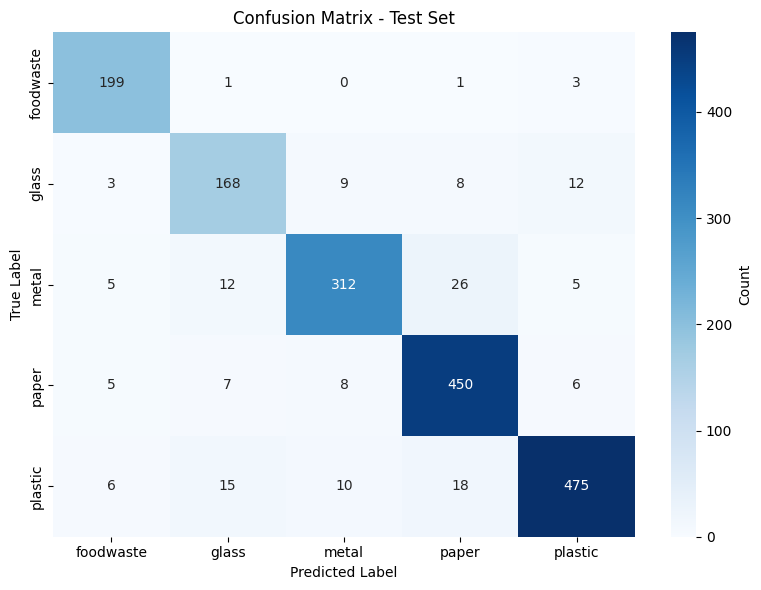


Per-Class Accuracy:
  - foodwaste      : 0.9755 (204 samples)
  - glass          : 0.8400 (200 samples)
  - metal          : 0.8667 (360 samples)
  - paper          : 0.9454 (476 samples)
  - plastic        : 0.9065 (524 samples)



✓ Model saved to:
  - models\waste_classification_model.pkl
  - models\waste_classification_model.h5

✓ Report generated:
  - HTML: report\waste_classification_report.html
  - Training curves: report\training_curves.png
  - Confusion matrix: report\confusion_matrix.png

TRAINING PIPELINE COMPLETED SUCCESSFULLY


In [ ]:
# Evaluasi model pada test set
# Hitung semua metrik performa

from datetime import datetime

print("="*80)
print("EVALUATING MODEL ON TEST SET")
print("="*80)

# Prediksi pada test set
predictions = model.predict(X_test_data, batch_size=BATCH_SIZE, verbose=0)
y_pred = np.argmax(predictions, axis=1)
y_true = y_test_data

# Hitung metrik performa
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"\nTest Set Performance Metrics:")
print(f"  - Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  - Precision: {test_precision:.4f}")
print(f"  - Recall:    {test_recall:.4f}")
print(f"  - F1-Score:  {test_f1:.4f}")

# Classification report detail
print(f"\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(str(REPORT_DIR / 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# Per-class accuracy
print(f"\nPer-Class Accuracy:")
per_class_metrics = {}
for i, class_name in enumerate(CLASS_NAMES):
    class_mask = y_true == i
    if np.sum(class_mask) > 0:
        class_accuracy = np.sum((y_pred == i) & class_mask) / np.sum(class_mask)
        class_count = np.sum(class_mask)
        per_class_metrics[class_name] = {
            'accuracy': class_accuracy,
            'count': class_count
        }
        print(f"  - {class_name:15s}: {class_accuracy:.4f} ({class_count} samples)")

# Export model ke format .pkl
model_path = MODEL_DIR / 'waste_classification_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

# Simpan model dalam format .h5
model.save(str(MODEL_DIR / 'waste_classification_model.h5'))

print(f"\n✓ Model saved to:")
print(f"  - {model_path}")
print(f"  - {MODEL_DIR / 'waste_classification_model.h5'}")

